In [135]:
import numpy as np
# import tensorflow as tf
from scipy.misc import imread, imresize, imsave
from skimage.color import gray2rgb,rgb2gray
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib.patches as patches
import menpo.io as mio
from menpo.shape.pointcloud import PointCloud
from time import time
from scipy.ndimage import zoom
from skimage.transform import rescale,resize
%matplotlib inline

In [2]:
# bounding box and image loading functions

def center_margin_bb(bb,img_bounds,margin=0.25):
    bb_size=([bb[0,2]-bb[0,0],bb[0,3]-bb[0,1]])
    margins=(np.max(bb_size)*(1+margin)-bb_size)/2

    bb_new=np.zeros_like(bb)
    bb_new[0,0]= np.maximum(bb[0,0]-margins[0],0)
    bb_new[0,2]= np.minimum(bb[0,2]+margins[0],img_bounds[1])
    bb_new[0,1]= np.maximum(bb[0,1]-margins[1],0)
    bb_new[0,3]= np.minimum(bb[0,3]+margins[1],img_bounds[0])
    return bb_new


def load_bb_files(bb_file_dirs):
    bb_files_dict={}
    for bb_file in bb_file_dirs:
        bb_mat=loadmat(bb_file)['bounding_boxes']    
        num_imgs=np.max(bb_mat.shape)
        for i in range(num_imgs):
            name=bb_mat[0][i][0][0][0][0]
            bb_init=bb_mat[0][i][0][0][1]-1 # matlab indicies
            bb_gt=bb_mat[0][i][0][0][2]-1 # matlab indicies
            if str(name) in bb_files_dict.keys():
                print str(name), 'already loaded from: ', bb_file
            bb_files_dict[str(name)]=(bb_init,bb_gt)
    return bb_files_dict


def load_bb_dictionary(bb_dir,mode,test_data='full'):
    
    if mode is 'TRAIN':
        bb_dirs = \
        ['bounding_boxes_afw.mat', 'bounding_boxes_helen_trainset.mat', 'bounding_boxes_lfpw_trainset.mat']
    else:
        if test_data is 'common':
            bb_dirs = \
            ['bounding_boxes_helen_testset.mat', 'bounding_boxes_lfpw_testset.mat']
        elif test_data is 'challenging':
            bb_dirs = ['bounding_boxes_ibug.mat']
        elif test_data is 'full':
            bb_dirs = \
            ['bounding_boxes_ibug.mat', 'bounding_boxes_helen_testset.mat', 'bounding_boxes_lfpw_testset.mat']
    
    if mode is 'TEST' and test_data is 'test':
        bb_files_dict = None
    else:
        bb_dirs = [os.path.join(bb_dir,dataset) for dataset in bb_dirs]
        bb_files_dict = load_bb_files(bb_dirs)
    
    return bb_files_dict


def crop_to_face_image(img,bb_dictinonary=None,gt=True,margin=0.25,image_size=256):
    
    name=img.path.name
    img_bounds=img.bounds()[1]
    
    if bb_dictinonary is None:
        bb_menpo=img.landmarks['PTS'].bounding_box().points
        bb = np.array([[bb_menpo[0,1],bb_menpo[0,0],bb_menpo[2,1],bb_menpo[2,0]]])
    else:
        if gt:
            bb = bb_dictinonary[name][1] #ground truth
        else:
            bb = bb_dictinonary[name][0] #init from face detector
    
    bb=center_margin_bb(bb,img_bounds,margin=margin)
    
    bb_pointcloud=PointCloud(np.array([[bb[0,1],bb[0,0]],
                                       [bb[0,3],bb[0,0]],
                                       [bb[0,3],bb[0,2]],
                                       [bb[0,1],bb[0,2]]]))
    
    face_crop = img.crop_to_pointcloud(bb_pointcloud).resize([image_size,image_size])
    
    return face_crop


def augment_face_image(img,image_size=256,crop_size=248,angle_range=30,flip=True):
    
    lim = image_size-crop_size
    min_crop_inds=np.random.randint(0,lim,2)
    max_crop_inds=min_crop_inds+crop_size    
    flip_rand = np.random.random() > 0.5
    rot_angle = 2*angle_range * np.random.random_sample() - angle_range
    
    if flip and flip_rand:
        rand_crop=img.crop(min_crop_inds,max_crop_inds).mirror().\
        rotate_ccw_about_centre(rot_angle).resize([image_size,image_size])
    else:
        rand_crop=img.crop(min_crop_inds,max_crop_inds).\
        rotate_ccw_about_centre(rot_angle).resize([image_size,image_size])
    
    return rand_crop


def load_menpo_image_list(img_dir,mode,bb_dictinonary=None,image_size=256,margin=0.25,bb_type='gt',test_data='full'):
    
    def crop_to_face_image_gt(img,bb_dictinonary=bb_dictinonary,margin=margin,image_size=image_size):
        return crop_to_face_image(img,bb_dictinonary,gt=True,margin=margin,image_size=image_size)
    def crop_to_face_image_init(img,bb_dictinonary=bb_dictinonary,margin=margin,image_size=image_size):
        return crop_to_face_image(img,bb_dictinonary,gt=False,margin=margin,image_size=image_size) 
    
    if mode is 'TRAIN':
        img_set_dir = os.path.join(img_dir,'training_set')
    
    else:
        img_set_dir = os.path.join(img_dir,test_data+'_set')
    
    image_menpo_list = mio.import_images(img_set_dir, verbose=True)

    if bb_type is 'gt':
        face_crop_image_list = image_menpo_list.map(crop_to_face_image_gt)
    else:
        face_crop_image_list = image_menpo_list.map(crop_to_face_image_init)
    
    if mode is 'TRAIN':
        out_image_list = face_crop_image_list.map(augment_face_image)
    else:
        out_image_list = face_crop_image_list
    
    return out_image_list   

In [101]:
#heat-maps functions

# look for: ECT-FaceAlignment/caffe/src/caffe/layers/data_heatmap.cpp
def gaussian(x, y, x0, y0, sigma=6):
    return 1./(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5 * ((x-x0)**2 + (y-y0)**2) / sigma**2)


def create_heat_maps(landmarks, num_landmarks=68, image_size=256, sigma=6):

    x, y = np.mgrid[0:image_size, 0:image_size]

    maps = np.zeros((image_size, image_size, num_landmarks))

    for i in range(num_landmarks):
        out = gaussian(x, y, landmarks[i,0], landmarks[i,1], sigma=sigma)
        maps[:, :, i] = (8./3)*sigma*out  # copied from ECT

    return maps


def load_data(img_list, batch_inds, image_size=256, c_dim=3, num_landmarks=68 , sigma=6, scale='255', save_landmarks=False):

    num_inputs = len(batch_inds)
    batch_menpo_images = img_list[batch_inds]

    images = np.zeros([num_inputs, image_size, image_size, c_dim]).astype('float32')
    maps = np.zeros([num_inputs, image_size, image_size, num_landmarks]).astype('float32')
    maps_small = np.zeros([num_inputs, image_size/4, image_size/4, num_landmarks]).astype('float32')


    if save_landmarks:
        landmarks = np.zeros([num_inputs, num_landmarks, 2]).astype('float32')
    else:
        landmarks = None

    for ind, img in enumerate(batch_menpo_images):
        lms = img.landmarks['PTS'].points
        images[ind, :, :, :] = np.rollaxis(img.pixels, 0, 3)
        maps[ind, :, :, :] = create_heat_maps(lms, num_landmarks, image_size, sigma)
        maps_small[ind, :, :, :]=zoom(maps[ind, :, :, :],(0.25,0.25,1))
        if save_landmarks:
            landmarks[ind, :, :] = lms

    if scale is '255':
        images = images * 255  # SAME AS ECT?
    elif scale is 'zero_center':
        images = 2 * images - 1

    return images, maps, maps_small, landmarks


def heat_maps_to_image(maps, landmarks=None, image_size=256, num_landmarks=68):

    if landmarks is None:
        landmarks = heat_maps_to_landmarks(maps, image_size=image_size, num_landmarks=num_landmarks)

    x, y = np.mgrid[0:image_size, 0:image_size]

    pixel_dist = np.sqrt(
        np.square(np.expand_dims(x, 2) - landmarks[:, 0]) + np.square(np.expand_dims(y, 2) - landmarks[:, 1]))

    nn_landmark = np.argmin(pixel_dist, 2)

    map_image = maps[x, y, nn_landmark]

    return map_image


def heat_maps_to_landmarks(maps,image_size=256,num_landmarks=68):

    landmarks=np.zeros((num_landmarks,2)).astype('float32')

    for m_ind in range(num_landmarks):
        landmarks[m_ind, :] = np.unravel_index(maps[:, :, m_ind].argmax(), (image_size, image_size))

    return landmarks

In [4]:
# save image output functions

def create_img_with_landmarks(image,landmarks,image_size=256,num_landmarks=68,scale='255'):
    
    image = image.reshape(image_size,image_size,-1)
    
    if scale is 'zero_center':
        image = 127.5 * (image+1)
    elif scale is '1':
        image = image * 255
    
    landmarks = landmarks.reshape(num_landmarks,2)
    landmarks = np.clip(landmarks,0,image_size)
    
    for (y, x) in landmarks.astype('int'):
        cv2.circle(image, (x, y), 1, (255, 0, 0), -1)
    
    return image


def merge_images_landmarks_maps(images, maps, image_size=256, num_landmarks=68, num_samples=9, scale='255'):
    images=images[:num_samples]
    cmap = plt.get_cmap('jet')
    
    row = int(np.sqrt(num_samples))
    merged = np.zeros([row * image_size, row * image_size * 2, 3])

    for idx, img in enumerate(images):
        i = idx // row
        j = idx % row
        
        img_lamdmarks = heat_maps_to_landmarks(maps[idx,:,:,:],image_size=image_size,num_landmarks=num_landmarks)
        map_image = heat_maps_to_image(maps[idx,:,:,:],img_lamdmarks,image_size=image_size,num_landmarks=num_landmarks)

        rgba_map_image = cmap(map_image)
        map_image = np.delete(rgba_map_image, 3, 2) * 255
        
        img = create_img_with_landmarks(img,img_lamdmarks,image_size,num_landmarks, scale=scale)

        merged[i * image_size:(i + 1) * image_size, (j * 2) * image_size:(j * 2 + 1) * image_size, :] = img
        merged[i * image_size:(i + 1) * image_size, (j * 2 + 1) * image_size:(j * 2 + 2) * image_size, :] = map_image

    return merged


In [5]:
# not using in project
def load(path):
    """takes as input the path to a .pts and returns a list of 
	tuples of floats containing the points in in the form:
	[(x_0, y_0, z_0),
	 (x_1, y_1, z_1),
	 ...
	 (x_n, y_n, z_n)]"""
    with open(path) as f:
        rows = [rows.strip() for rows in f]
    
    """Use the curly braces to find the start and end of the point data""" 
    head = rows.index('{') + 1
    tail = rows.index('}')

    """Select the point data split into coordinates"""
    raw_points = rows[head:tail]
    coords_set = [point.split() for point in raw_points]

    """Convert entries from lists of strings to tuples of floats"""
    points = [tuple([float(point) for point in coords]) for coords in coords_set]
    return np.asarray(points) 

In [6]:
bb_dir = '/Users/arik/Desktop/DATA/face_data/300W/Bounding_Boxes/'
img_dir = '/Users/arik/Desktop/DATA/face_data/conventional_landmark_detection_dataset/'
ect_path='/Users/arik/Dropbox/a_mac_thesis/test_landmark_detector_art/ECT-FaceAlignment-master/imgs/'

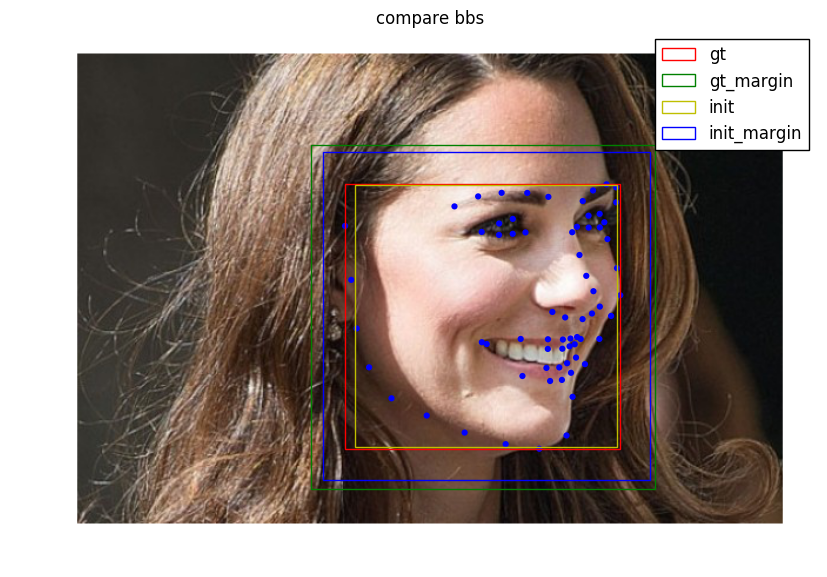

In [136]:
########## compare gt and init bbs
mode='TEST'
test_data='challenging'
imgs_dict = load_bb_dictionary(bb_dir,mode,test_data)

name='image_007'
name='image_008_1'

# 300w data
img_path='/Users/arik/Desktop/DATA/face_data/conventional_landmark_detection_dataset/challenging_set/'+name+'.jpg'
lmx_path='/Users/arik/Desktop/DATA/face_data/conventional_landmark_detection_dataset/challenging_set/'+name+'.pts'

img=imread(img_path)
img_bounds=(img.shape[0]-1,img.shape[1]-1)
lmx=load(lmx_path) - 1 # matlab indicies

bb_gt=imgs_dict[name+'.jpg'][1]
bb_init=imgs_dict[name+'.jpg'][0]

bb_gt_margin=center_margin_bb(bb_gt,img_bounds)
bb_init_margin=center_margin_bb(bb_init,img_bounds)



fig=plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(img)
plt.scatter(lmx[:,0],lmx[:,1],edgecolors='none')

bb_plt=patches.Rectangle([bb_gt[0,0],bb_gt[0,1]], bb_gt[0,2]-bb_gt[0,0], bb_gt[0,3]-bb_gt[0,1],
                         edgecolor='r',fill=False,label="gt")
ax.add_patch(bb_plt)

bb_plt=patches.Rectangle([bb_gt_margin[0,0],bb_gt_margin[0,1]],bb_gt_margin[0,2]-bb_gt_margin[0,0],
                         bb_gt_margin[0,3]-bb_gt_margin[0,1],edgecolor='g',fill=False,label="gt_margin")
ax.add_patch(bb_plt)

bb_plt=patches.Rectangle([bb_init[0,0],bb_init[0,1]], bb_init[0,2]-bb_init[0,0], bb_init[0,3]-bb_init[0,1],
                         edgecolor='y',fill=False,label="init")
ax.add_patch(bb_plt)

bb_plt=patches.Rectangle([bb_init_margin[0,0],bb_init_margin[0,1]],bb_init_margin[0,2]-bb_init_margin[0,0],
                         bb_init_margin[0,3]-bb_init_margin[0,1],edgecolor='b',fill=False,label="init_margin")
ax.add_patch(bb_plt)
plt.axis('off')
plt.title('compare bbs')
plt.legend()

del(imgs_dict)

/Users/arik/anaconda2/envs/tf_1_7/lib/python2.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/arik/anaconda2/envs/tf_1_7/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


diff gt crop to ect (landmarks): 135.274497693


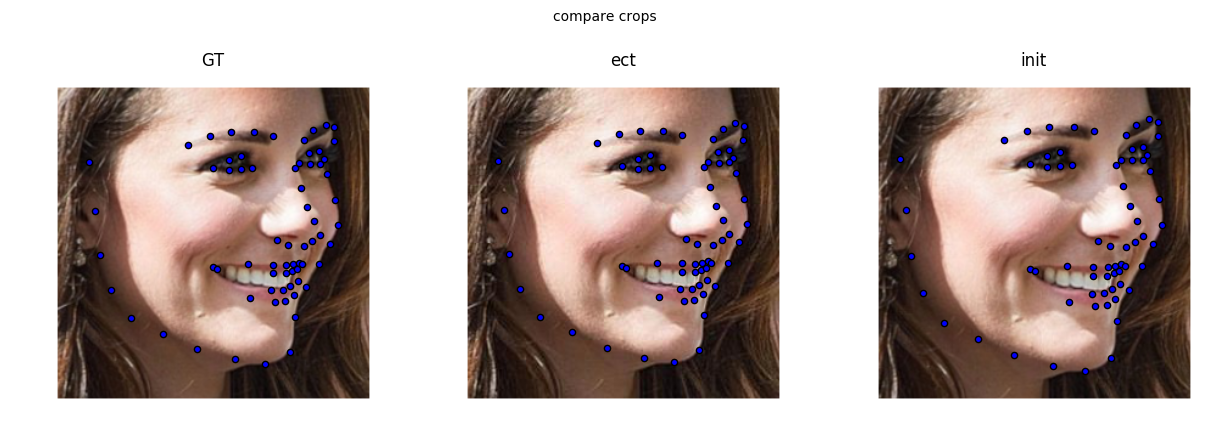

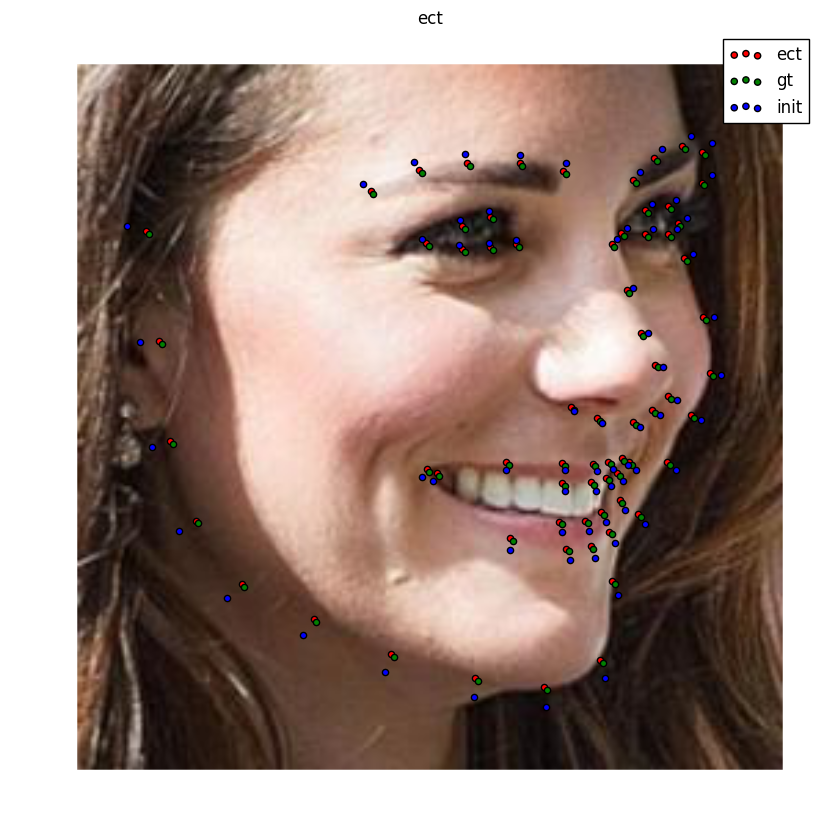

In [137]:
########## compare to ECT crops

mode='TEST'
test_data='challenging'
imgs_dict = load_bb_dictionary(bb_dir,mode,test_data)

new_size=256
# ect data
img_ect_path=ect_path+name+'.jpg'
lmx_ect_path=ect_path+name+'.pts'

img_crop_ect = imread(img_ect_path)
lmx_crop_ect = load(lmx_ect_path) - 1 # matlab indicies

min_pts=np.min(lmx_crop_ect,0)
max_pts=np.max(lmx_crop_ect,0)
bb_size=max_pts-min_pts
bb_ect=np.array([[min_pts[0],min_pts[1],max_pts[0],max_pts[1]]])


img_crop_gt=img[bb_gt_margin[0,1]:bb_gt_margin[0,3],bb_gt_margin[0,0]:bb_gt_margin[0,2],:]
lmx_gt=lmx-bb_gt_margin[0,:2]
img_crop_gt_rescale=imresize(img_crop_gt,[new_size,new_size])
lmx_gt_rescale=(lmx_gt/img_crop_gt.shape[0])*new_size

img_crop_init=img[bb_init_margin[0,1]:bb_init_margin[0,3],bb_init_margin[0,0]:bb_init_margin[0,2],:]
lmx_init=lmx-bb_init_margin[0,:2]
img_crop_init_rescale=imresize(img_crop_init,[new_size,new_size])
lmx_init_rescale=(lmx_init/img_crop_init.shape[0])*new_size

plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.imshow(img_crop_gt_rescale)
plt.scatter(lmx_gt_rescale[:,0],lmx_gt_rescale[:,1])
plt.axis('off')
plt.title('GT')
plt.subplot(1,3,2)
plt.imshow(img_crop_ect)
plt.scatter(lmx_crop_ect[:,0],lmx_crop_ect[:,1])
plt.axis('off')
plt.title('ect')
plt.subplot(1,3,3)
plt.imshow(img_crop_init_rescale)
plt.scatter(lmx_init_rescale[:,0],lmx_init_rescale[:,1])
plt.axis('off')
plt.title('init')
plt.suptitle('compare crops')

plt.figure(figsize=[10,10])
plt.imshow(img_crop_ect)
plt.scatter(lmx_crop_ect[:,0],lmx_crop_ect[:,1],label="ect",c='r')
plt.scatter(lmx_gt_rescale[:,0],lmx_gt_rescale[:,1], label="gt",c='g')
plt.scatter(lmx_init_rescale[:,0],lmx_init_rescale[:,1], label="init",c='b')
plt.legend()
plt.axis('off')
plt.title('ect')

print 'diff gt crop to ect (landmarks):', np.sum(lmx_gt_rescale-lmx_crop_ect)
del(imgs_dict)

landmark diff using "crop_to_pointcloud_proportion" with 0.125 margin vs. "crop_to_pointcloud" using "center_margin_bb" with 0.25 margin:
0.0


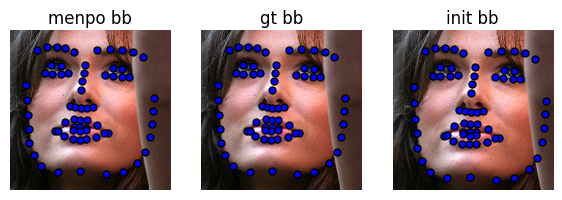

In [9]:
###### compare to menpo crop_to_pointcloud vs. crop_to_pointcloud_proportion


imageList = mio.import_images(img_dir+'/training_set')
mode='TRAIN'
imgs_dict_all = load_bb_dictionary(bb_dir,mode)


im=imageList[0]
name=im.path.name
im_bounds=im.bounds()[1]

bb_gt0= imgs_dict_all[name][1]
bb_gt=center_margin_bb(bb_gt0,im_bounds,margin=0.25)
bb_gt_menpo=PointCloud(np.array([[bb_gt[0,1],bb_gt[0,0]],
                                 [bb_gt[0,3],bb_gt[0,0]],
                                 [bb_gt[0,3],bb_gt[0,2]],
                                 [bb_gt[0,1],bb_gt[0,2]]]))

bb_init0= imgs_dict_all[name][0]
bb_init=center_margin_bb(bb_init0,im_bounds)
bb_init_menpo=PointCloud(np.array([[bb_init[0,1],bb_init[0,0]],
                                   [bb_init[0,3],bb_init[0,0]],
                                   [bb_init[0,3],bb_init[0,2]],
                                   [bb_init[0,1],bb_init[0,2]]]))


bb_menpo=im.landmarks['PTS'].bounding_box().points
bb_from_pts=np.array([[bb_menpo[0,1],bb_menpo[0,0],bb_menpo[2,1],bb_menpo[2,0]]])
bb_from_pts_sqr = center_margin_bb(bb_from_pts,im_bounds,margin=0)

bb_from_pts_sqr_menpo=PointCloud(np.array([[bb_from_pts_sqr[0,1],bb_from_pts_sqr[0,0]],
                                           [bb_from_pts_sqr[0,3],bb_from_pts_sqr[0,0]],
                                           [bb_from_pts_sqr[0,3],bb_from_pts_sqr[0,2]],
                                           [bb_from_pts_sqr[0,1],bb_from_pts_sqr[0,2]]]))

plt.subplot(1,3,1)
im.crop_to_pointcloud_proportion(bb_from_pts_sqr_menpo,0.125,minimum=False).view_landmarks(group='PTS')
plt.title('menpo bb')
plt.subplot(1,3,3)
im.crop_to_pointcloud(bb_init_menpo).view_landmarks(group='PTS')
plt.title('init bb')
plt.subplot(1,3,2)
im.crop_to_pointcloud(bb_gt_menpo).view_landmarks(group='PTS')
plt.title('gt bb')


print 'landmark diff using "crop_to_pointcloud_proportion" with 0.125 margin vs. "crop_to_pointcloud" \
using "center_margin_bb" with 0.25 margin:'
print np.sum(im.crop_to_pointcloud_proportion(bb_from_pts_sqr_menpo,0.125,minimum=False).\
             landmarks['PTS'].points-im.crop_to_pointcloud(bb_gt_menpo).landmarks['PTS'].points)

del(imgs_dict_all)

Found 2 assets, index the returned LazyList to import.
diff gt crop to ect: 88.5933782935
diff gt manualy rescaled gt crop to ect: 135.274497693
diff gt crop to manualy rescaled gt crop: -46.6811193993


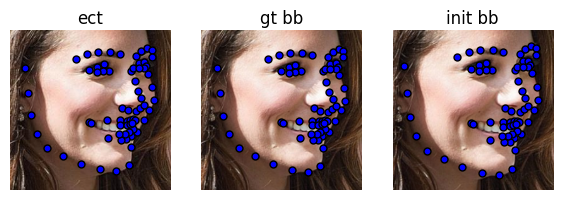

In [10]:
####### compare to ect

test_data='challenging'
mode='TEST'
imgs_dict = load_bb_dictionary(bb_dir,mode,test_data)

imageListECT = mio.import_images(ect_path, verbose=True)
im_ect=imageListECT[1]

name=im_ect.path.name

im300 = mio.import_image(img_dir+'/challenging_set/'+name)
im300_bounds= im300.bounds()[1]

bb_gt0= imgs_dict[name][1]
bb_gt=center_margin_bb(bb_gt0,im300_bounds)
bb_gt_menpo=PointCloud(np.array([[bb_gt[0,1],bb_gt[0,0]],
                                 [bb_gt[0,3],bb_gt[0,0]],
                                 [bb_gt[0,3],bb_gt[0,2]],
                                 [bb_gt[0,1],bb_gt[0,2]]]))

bb_init0= imgs_dict[name][0]
bb_init=center_margin_bb(bb_init0,im300_bounds)

bb_init_menpo=PointCloud(np.array([[bb_init[0,1],bb_init[0,0]],
                                   [bb_init[0,3],bb_init[0,0]],
                                   [bb_init[0,3],bb_init[0,2]],
                                   [bb_init[0,1],bb_init[0,2]]]))

im_300_crop_gt=im300.crop_to_pointcloud(bb_gt_menpo)

im_300_crop_init=im300.crop_to_pointcloud(bb_init_menpo)


plt.subplot(1,3,1)
im_ect.view_landmarks(group='PTS')
plt.title('ect')
plt.subplot(1,3,2)
im_300_crop_gt.resize([256,256]).view_landmarks(group='PTS')
plt.title('gt bb')
plt.subplot(1,3,3)
im_300_crop_init.resize([256,256]).view_landmarks(group='PTS')
plt.title('init bb')

print 'diff gt crop to ect:', np.sum(im_300_crop_gt.resize([256,256]).landmarks['PTS'].points-im_ect.landmarks['PTS'].points)
print 'diff gt manualy rescaled gt crop to ect:', np.sum(lmx_gt_rescale-im_ect.landmarks['PTS'].points)
print 'diff gt crop to manualy rescaled gt crop:', np.sum(im_300_crop_gt.resize([256,256]).landmarks['PTS'].points-lmx_gt_rescale)

del(imgs_dict)

Found 3148 assets, index the returned LazyList to import.
Found 3148 assets, index the returned LazyList to import.


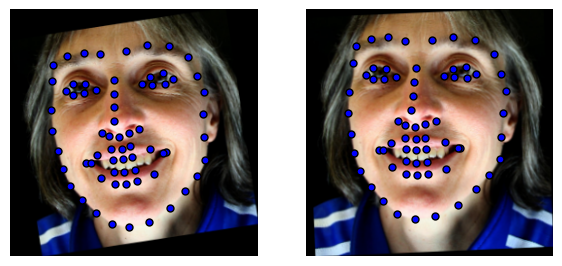

In [11]:
###### check augmentation options

bb_dir = '/Users/arik/Desktop/DATA/face_data/300W/Bounding_Boxes/'
img_dir = '/Users/arik/Desktop/DATA/face_data/conventional_landmark_detection_dataset/'
mode='TRAIN'
test_data='test'

bb_dict = load_bb_dictionary(bb_dir,mode,test_data=test_data)
list_gt = load_menpo_image_list(img_dir,mode,bb_dictinonary=bb_dict,bb_type='gt',test_data=test_data)
list_init = load_menpo_image_list(img_dir,mode,bb_dictinonary=bb_dict,bb_type='init',test_data=test_data)

ind=55
plt.subplot(1,2,1)
list_gt[ind].view_landmarks()
plt.subplot(1,2,2)
list_init[ind].view_landmarks()

In [12]:
bb_dir = '/Users/arik/Desktop/DATA/face_data/300W/Bounding_Boxes/'
img_dir = '/Users/arik/Desktop/DATA/face_data/conventional_landmark_detection_dataset/'
mode='TRAIN'

training_img_bb = load_bb_dictionary(bb_dir,mode)
training_img_menpo_list = load_menpo_image_list(img_dir,mode,training_img_bb,bb_type='gt')


Found 3148 assets, index the returned LazyList to import.


In [13]:
np.random.seed(0)

batch_num=3
batch_size=10

inds=np.arange(len(training_img_menpo_list))

np.random.shuffle(inds)

batch_inds=inds[batch_num*batch_size:batch_num*batch_size+batch_size]

t=time()
images, maps, maps_small, landmarks = load_data(training_img_menpo_list,batch_inds,save_landmarks=True)
t1=time() - t
print 'batch loading time (sec):', t1

batch loading time (sec): 4.31799507141


diff landmarks to heatmap peak response: 0.669163


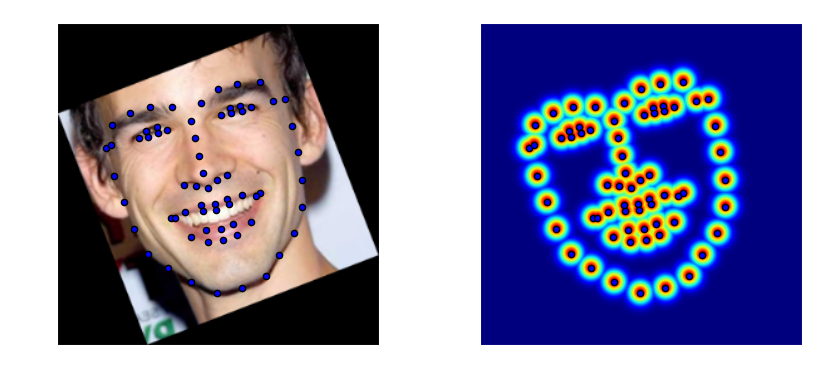

In [14]:
# check loading function (image/landmarks/heatmaps array)
plt.figure(figsize=[10,5])
ind=0

max_map_lmx=heat_maps_to_landmarks(maps[ind,:,:,:])

plt.subplot(1,2,1)
plt.imshow(images[ind,:,:,:].astype('uint8'))
plt.scatter(landmarks[ind,:,1],landmarks[ind,:,0])

plt.axis('off')
plt.subplot(1,2,2)
map_vis=heat_maps_to_image(maps[ind,:,:,:],landmarks[ind,:,:])
plt.imshow(map_vis)
plt.scatter(landmarks[ind,:,1],landmarks[ind,:,0])

plt.axis('off')

print 'diff landmarks to heatmap peak response:', np.sum(landmarks[ind,:,:]-max_map_lmx)

(-0.5, 1535.5, 767.5, -0.5)

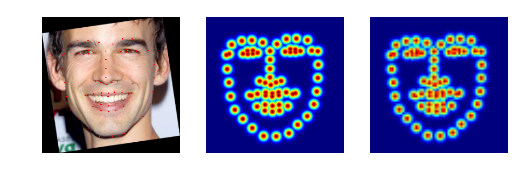

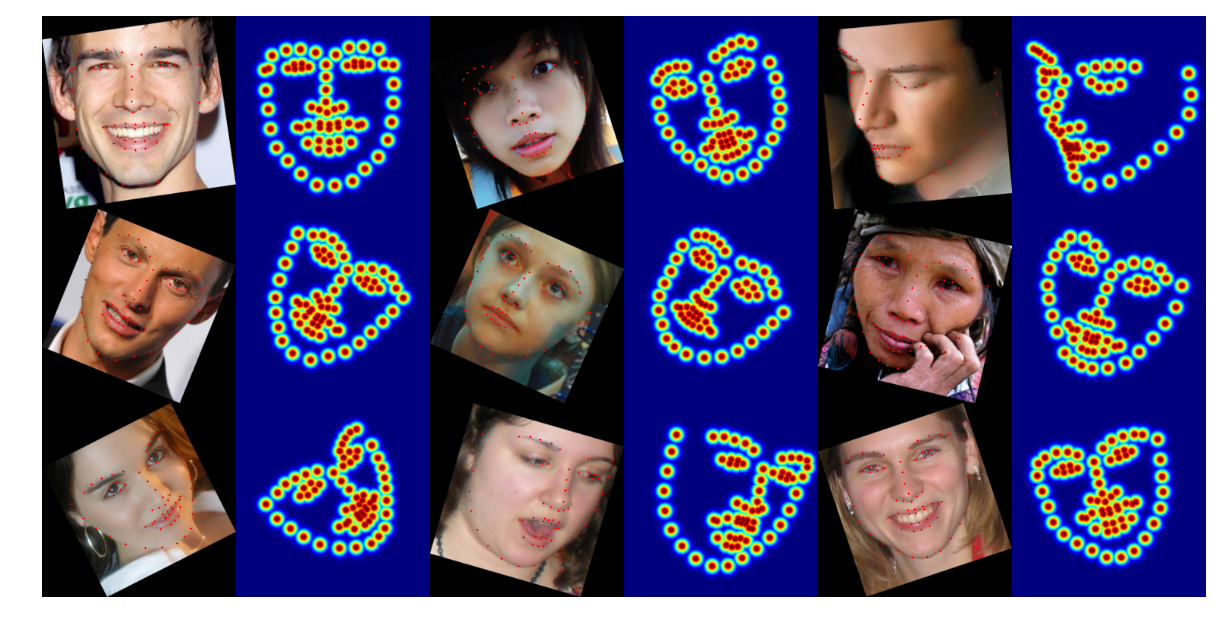

In [105]:
# check create_img_with_landmarks, merge_images_with_landmarks functions

scale='1'
images, maps, maps_small,landmarks = load_data(training_img_menpo_list,batch_inds,save_landmarks=True,scale=scale)

ind = 0
img = images[ind,:,:,:]
img_maps = maps[ind,:,:,:]
img_maps_small = maps_small[ind,:,:,:]

img_landmarks = landmarks[ind,:,:]
landmarks_from_maps = heat_maps_to_landmarks(img_maps)
heatmap_image = heat_maps_to_image(img_maps,img_landmarks)
heatmap_image_small = heat_maps_to_image(img_maps_small,image_size=64)

out_img = create_img_with_landmarks(img,landmarks_from_maps,scale=scale)
out_map = create_img_with_landmarks(img,landmarks_from_maps)

plt.subplot(1,3,1)
plt.imshow(out_img.astype('uint8'))
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(heatmap_image)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(heatmap_image_small)
plt.axis('off')

plt.figure(figsize=[15,10])
merged=merge_images_landmarks_maps(images, maps, num_samples=9,scale=scale)
plt.imshow(merged.astype('uint8'))
plt.axis('off')

In [46]:
t=time()
a= zoom(img_maps,(0.25,0.25,1))
t1=time()-t
# print a.shape
b= resize(img_maps/255,(64,64))
t2=time()-t1

# print b.shape
c= rescale(img_maps/255,(0.25,0.25))
# print c.shape
t3=time()-t2

# image_rescaled = rescale(image, 1.0 / 4.0, anti_aliasing=False)
# image_resized = resize(image, (image.shape[0] / 4, image.shape[1] / 4),
#                        anti_aliasing=True)

print t1,t2,t3

0.299226999283 1523364824.83 0.400183916092


In [35]:
rescale?

In [78]:
a_img = heat_maps_to_image(a,image_size=64)
b_img = heat_maps_to_image(b,image_size=64)
c_img = heat_maps_to_image(c,image_size=64)
d_img = heat_maps_to_image(hm,image_size=64)

(-0.5, 63.5, 63.5, -0.5)

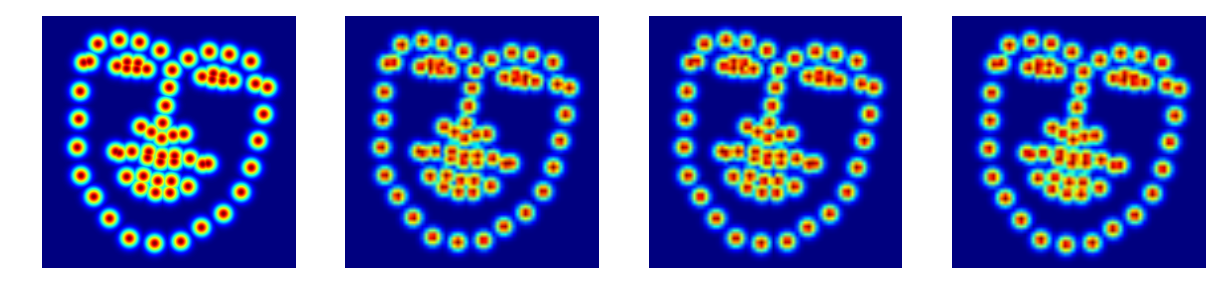

In [79]:
plt.figure(figsize=[15,5])
plt.subplot(1,4,1)
plt.imshow(heatmap_image)
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(a_img)
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(b_img)
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(d_img)
plt.axis('off')

In [77]:
hm=create_heat_maps(lms_small, num_landmarks=68, image_size=64, sigma=1.5)

In [61]:
def create_heat_maps(landmarks, num_landmarks=68, image_size=256, sigma=6):

    x, y = np.mgrid[0:image_size, 0:image_size]

    maps = np.zeros((image_size, image_size, num_landmarks))

    for i in range(num_landmarks):
        out = gaussian(x, y, landmarks[i,0], landmarks[i,1], sigma=sigma)
        maps[:, :, i] = (8./3)*sigma*out  # copied from ECT

    return maps


In [62]:
lms_small=(img_landmarks/4)

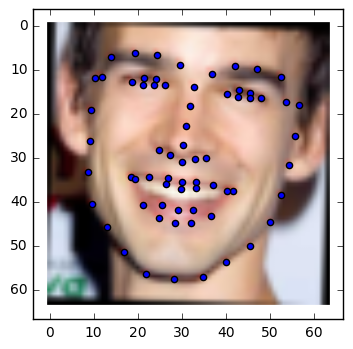

In [76]:
plt.imshow(imresize(out_img,0.25).astype('uint8'))
plt.scatter(lms_small[:,1],lms_small[:,0])

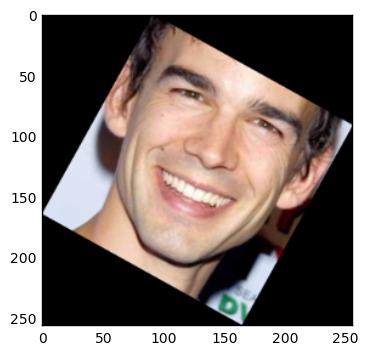

In [71]:
plt.imshow(np.rollaxis(training_img_menpo_list[batch_inds[0]].pixels,0,3))

In [81]:
plt.imsave('d_im.png',d_img)

In [82]:
a_lan=heat_maps_to_landmarks(a,image_size=64)
d_lan=heat_maps_to_landmarks(hm,image_size=64)

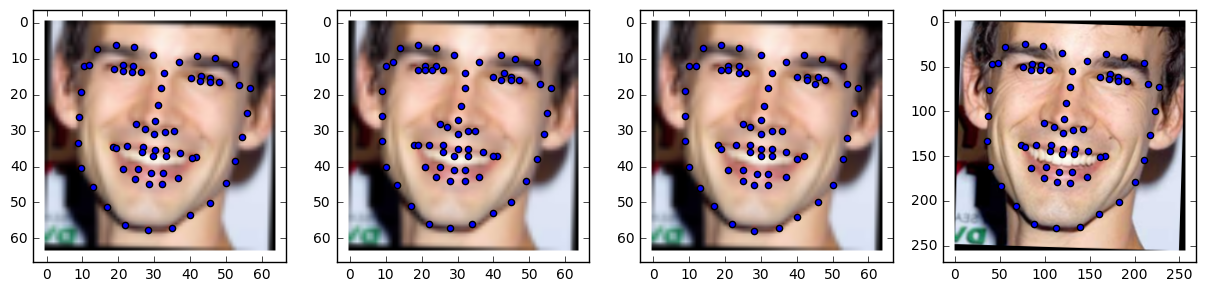

In [86]:
plt.figure(figsize=[15,5])
plt.subplot(1,4,1)
plt.imshow(imresize(out_img,0.25).astype('uint8'))
plt.scatter(lms_small[:,1],lms_small[:,0])
plt.subplot(1,4,2)
plt.imshow(imresize(out_img,0.25).astype('uint8'))
plt.scatter(a_lan[:,1],a_lan[:,0])
plt.subplot(1,4,3)
plt.imshow(imresize(out_img,0.25).astype('uint8'))
plt.scatter(d_lan[:,1],d_lan[:,0])
plt.subplot(1,4,4)
plt.imshow(out_img.astype('uint8'))
plt.scatter(img_landmarks[:,1],img_landmarks[:,0])

In [88]:
orig=landmarks_from_maps/256
a_1=a_lan/64
d_1=d_lan/64

In [91]:
print np.sum(orig-a_1)
print np.sum(orig-d_1)

0.710938
0.0078125


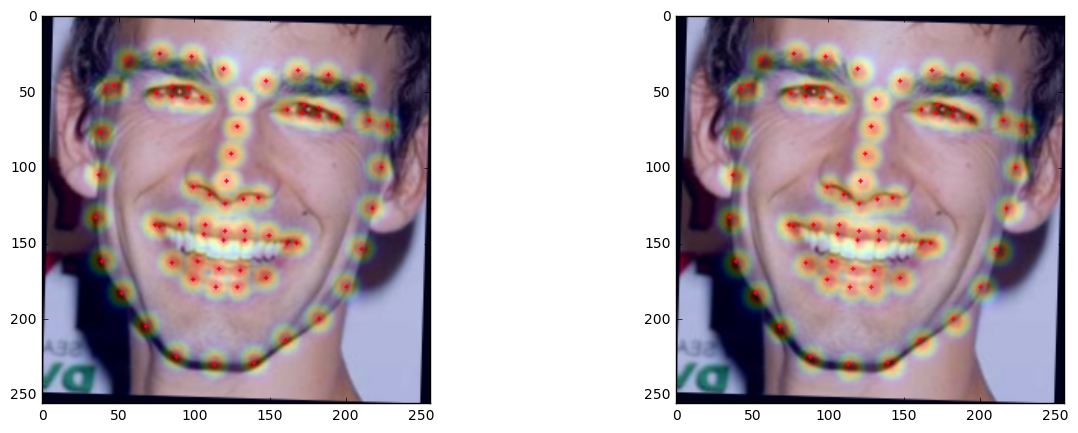

In [99]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.imshow(out_img.astype('uint8'))
plt.imshow(imresize(a_img,(256,256)),alpha=0.2)
plt.subplot(1,2,2)
plt.imshow(out_img.astype('uint8'))
plt.imshow(imresize(d_img,(256,256)),alpha=0.2)

In [126]:
def merge_compare_maps(maps_small, maps, image_size=64, num_landmarks=68, num_samples=9):
    maps_small=maps_small[:num_samples]
    maps = maps[:num_samples]
    maps_rescale = zoom(maps,(1,0.25,0.25,1))
    cmap = plt.get_cmap('jet')
    
    row = int(np.sqrt(num_samples))
    merged = np.zeros([row * image_size, row * image_size * 2, 3])

    for idx, map_small in enumerate(maps_small):
        i = idx // row
        j = idx % row
        
        map_image_small = heat_maps_to_image(map_small,image_size=image_size,num_landmarks=num_landmarks)
        map_image = heat_maps_to_image(maps_rescale[idx,:,:,:],image_size=image_size,num_landmarks=num_landmarks)

        rgba_map_image = cmap(map_image)
        map_image = np.delete(rgba_map_image, 3, 2) * 255
        
        rgba_map_image_small = cmap(map_image_small)
        map_image_small = np.delete(rgba_map_image_small, 3, 2) * 255
        

        merged[i * image_size:(i + 1) * image_size, (j * 2) * image_size:(j * 2 + 1) * image_size, :] = map_image_small
        merged[i * image_size:(i + 1) * image_size, (j * 2 + 1) * image_size:(j * 2 + 2) * image_size, :] = map_image

    return merged

(-0.5, 383.5, 191.5, -0.5)

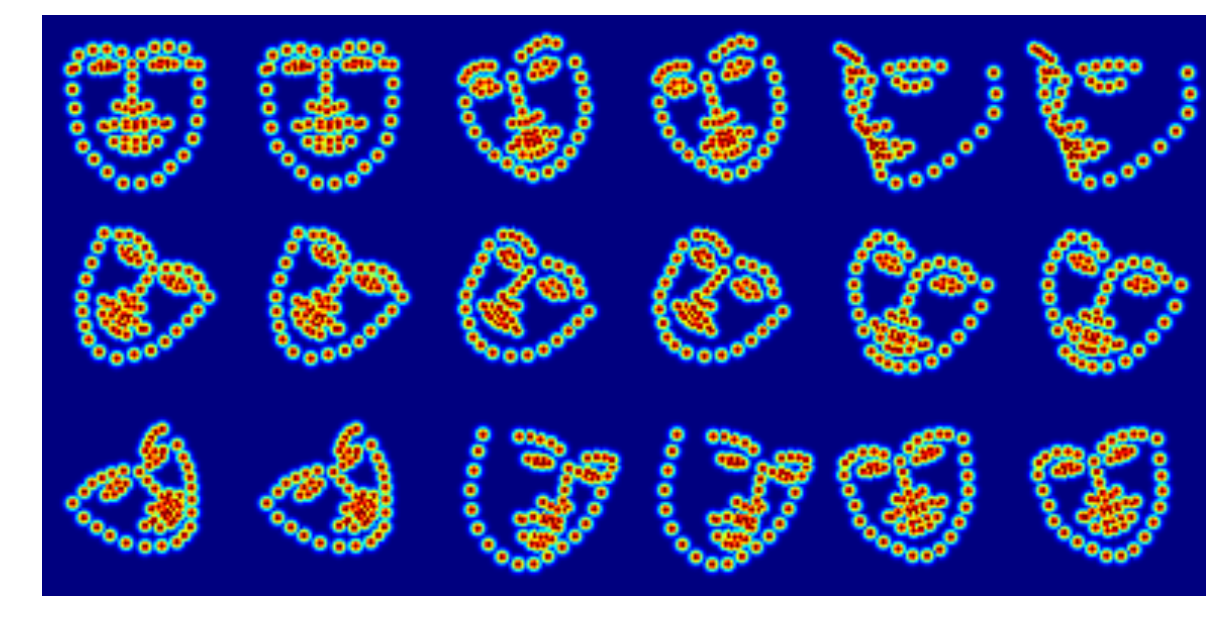

In [125]:
plt.figure(figsize=[15,10])
merged_maps=merge_compare_maps(maps_small, maps, num_samples=9,scale=scale)
plt.imshow(merged_maps.astype('uint8'))
plt.axis('off')

In [132]:
import tensorflow as tf

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa